<a href="https://colab.research.google.com/github/heyitzrizki/final-project-ds49-group3/blob/main/modeling/Model_Development_no_outlier_partial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.1 Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Train test dan Hyperparameter Tuning
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, fbeta_score, roc_auc_score, roc_curve,
    classification_report, confusion_matrix
)
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import sklearn

warnings.filterwarnings("ignore")

# 0.2 Load Dataset

In [2]:
url = 'https://raw.githubusercontent.com/heyitzrizki/final-project-ds49-group3/refs/heads/main/data/df_no_outlier_partial_encoded.csv'
df = pd.read_csv(url)
df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_time,item_price_range,...,store_primary_category_vegan,store_primary_category_vegetarian,store_primary_category_vietnamese,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,order_protocol_Unknown
0,4,3441,4,557.0,1239.0,33,14,21,62,682,...,False,False,False,False,False,False,False,False,False,False
1,1,1900,1,1400.0,1400.0,1,2,2,67,0,...,False,False,False,True,False,False,False,False,False,False
2,1,1900,1,1900.0,1900.0,1,0,0,29,0,...,False,False,False,False,False,False,False,False,False,False
3,6,6900,5,600.0,1800.0,1,1,2,51,1200,...,False,False,False,False,False,False,False,False,False,False
4,3,3900,3,1100.0,1600.0,6,6,9,39,500,...,False,False,False,False,False,False,False,False,False,False


# Log Data Skewed

## 1.1 Verify Numerical Columns Skewness

In [3]:
continuous_features = [
    'total_items', 'num_distinct_items',
                      'min_item_price', 'max_item_price',
                      'total_onshift_partners', 'total_busy_partners',
                      'total_outstanding_orders'
]

df_skew_verify = df.loc[:, continuous_features]

In [4]:
skew_ft = []

for i in continuous_features:
    # list of skew for each corresponding feature
    skew_ft.append(abs(df_skew_verify[i].skew()))

df_skewed = pd.DataFrame(
    {
        "Columns": continuous_features,
        "Abs_Skew": skew_ft
    }
)

sk_features = df_skewed[df_skewed["Abs_Skew"] > 0.5]["Columns"].tolist()
print("List of skewed features:\n")
print(sk_features)

List of skewed features:

['total_items', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_partners', 'total_busy_partners', 'total_outstanding_orders']


In [5]:
# loop over i (features) to calculate Log of surfaces
for i in sk_features:

    df[i] = np.log((df[i]) + 1)

Text(0, 0.5, '')

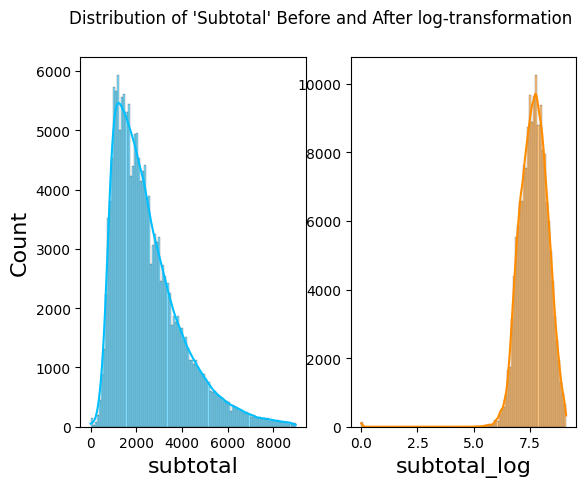

In [6]:
# Log transformation of the target variable "subtotal"
df["subtotal_log"] = np.log1p(df["subtotal"])

# Plot the distribution before and after transformation
fig, axes = plt.subplots(1, 2)
fig.suptitle("Distribution of 'Subtotal' Before and After log-transformation")
fontsize = 16

# before log transformation
p = sns.histplot(
    ax=axes[0],
    x=df["subtotal"],
    kde=True,
    bins=100,
    color="deepskyblue"
)
p.set_xlabel("subtotal", fontsize=fontsize)
p.set_ylabel("Count", fontsize=fontsize)

# after log transformation
q = sns.histplot(
    ax=axes[1],
    x=df["subtotal_log"],
    kde=True,
    bins=100,
    color="darkorange"
)

q.set_xlabel("subtotal_log", fontsize=fontsize)
q.set_ylabel("", fontsize=fontsize)

In [7]:
# Drop the original SalePrice
df.drop(
    columns=["subtotal"],
    inplace=True
)

In [8]:
df.head()

,total_items,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_time,item_price_range,store_primary_category_afghan,...,store_primary_category_vegetarian,store_primary_category_vietnamese,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,order_protocol_Unknown,subtotal_log
0,1.609438,1.609438,6.324359,7.122867,3.526361,2.708050,3.091042,62,682,False,...,False,False,False,False,False,False,False,False,False,8.143808
1,0.693147,0.693147,7.244942,7.244942,0.693147,1.098612,1.098612,67,0,False,...,False,False,True,False,False,False,False,False,False,7.550135
2,0.693147,0.693147,7.550135,7.550135,0.693147,0.000000,0.000000,29,0,False,...,False,False,False,False,False,False,False,False,False,7.550135
3,1.945910,1.791759,6.398595,7.496097,0.693147,0.693147,1.098612,51,1200,False,...,False,False,False,False,False,False,False,False,False,8.839422
4,1.386294,1.386294,7.003974,7.378384,1.945910,1.945910,2.302585,39,500,False,...,False,False,False,False,False,False,False,False,False,8.268988


# Data Splitting and Standardization

#### 2.1 Splitting the Dataset into Train and Test

In [9]:
y = df["subtotal_log"] #Target
X = df.drop(columns="subtotal_log")
print(X.shape)
print(y.shape)

(167911, 88)
(167911,)


In [10]:
# Create 150 quantile bins for even distribution
bins = np.linspace(0, len(y), 150)
y_binned = np.digitize(y, bins)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y_binned,
    shuffle=True,
    random_state=42
)

print(f"X_train:{X_train.shape}\ny_train:{y_train.shape}")
print(f"\nX_test:{X_test.shape}\ny_test:{y_test.shape}")

X_train:(134328, 88)
y_train:(134328,)

X_test:(33583, 88)
y_test:(33583,)


In [11]:
y_test.head()

,subtotal_log
121154,8.206856
77878,6.731018
115613,7.981392
1906,7.783641
86091,8.111928


#### 2.2 Data Standarization

In [12]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),
                       columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test),
                      columns=X_test.columns, index=X_test.index)

In [13]:
X_train

,total_items,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_time,item_price_range,store_primary_category_afghan,...,store_primary_category_vegan,store_primary_category_vegetarian,store_primary_category_vietnamese,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,order_protocol_Unknown
39999,-1.356915,-0.584963,0.545332,0.085757,-1.022487,-1.081174,-1.070050,-0.761905,-0.482759,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
89624,-0.563171,-0.584963,0.460519,-0.093612,0.891598,0.828201,0.938108,-0.761905,-0.482759,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
167096,0.436829,0.000000,-0.154512,-1.051827,-0.598921,-0.563237,-0.494948,-0.333333,-0.344828,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
157832,-0.563171,0.000000,0.303246,0.187329,0.657108,0.506867,0.635281,-0.095238,-0.037241,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
72088,0.793745,1.000000,-0.862909,-1.394322,-0.469192,-0.396499,-0.070050,0.666667,-0.103448,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63949,-0.563171,0.000000,0.362798,0.078901,0.021871,0.063183,0.247038,0.428571,-0.206897,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70634,-0.563171,0.000000,0.456952,-0.101155,-1.307198,-1.180952,-0.800473,-0.190476,-0.482759,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
133891,-0.563171,0.000000,-0.769546,-0.045307,0.483839,0.472637,0.635281,0.571429,0.586207,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144200,-0.563171,0.000000,-0.192616,0.078901,-1.430246,-1.081174,-1.070050,-0.809524,0.366897,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## 2.3 Backward Stepwise Regression

In [14]:
Selected_Features = []


def backward_regression(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05, verbose=True):
    """To select feature with Backward Stepwise Regression

    Args:
        X -- features values
        y -- target variable
        initial_list -- features header
        threshold_in -- pvalue threshold of features to keep
        threshold_out -- pvalue threshold of features to drop
        verbose -- true to produce lots of logging output

    Returns:
        list of selected features for modeling
    """
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature: {worst_feature}, {worst_pval}")
        if not changed:
            break
    Selected_Features.append(included)
    print(f"\nSelected Features:\n{Selected_Features[0]}")


# Application of the backward regression function on our training data
backward_regression(X_train, y_train)

worst_feature: store_primary_category_malaysian, 0.9987385382761049
worst_feature: store_primary_category_lebanese, 0.9874035427761141
worst_feature: store_primary_category_belgian, 0.9214222501526429
worst_feature: store_primary_category_convenience-store, 0.893379647022625
worst_feature: store_primary_category_breakfast, 0.8926902076633325
worst_feature: store_primary_category_african, 0.8405682691727512
worst_feature: store_primary_category_chinese, 0.819070109523651
worst_feature: store_primary_category_spanish, 0.800068268821845
worst_feature: store_primary_category_persian, 0.7779148746757916
worst_feature: store_primary_category_russian, 0.7708970236557471
worst_feature: store_primary_category_french, 0.7649677570218769
worst_feature: store_primary_category_mediterranean, 0.7671468352944574
worst_feature: order_protocol_6.0, 0.7245405707734969
worst_feature: store_primary_category_alcohol-plus-food, 0.6588462654576914
worst_feature: store_primary_category_cheese, 0.6206892046841

In [15]:
# Keep the selected features only
X_train = X_train.loc[:, Selected_Features[0]]
X_test = X_test.loc[:, Selected_Features[0]]

## 2.4 Variance Inflation Factor

In [16]:
# Here we calculate VIF for each feature
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    X_train.values, i) for i in range(X_train.shape[1])]

# VIF results in a table
vif["features"] = X_train.columns
vif.round(1)

,VIF Factor,features
0,4.8,total_items
1,5.3,num_distinct_items
2,3.0,min_item_price
3,3.4,max_item_price
4,1.1,total_outstanding_orders
5,1.0,delivery_time
6,4.2,item_price_range
7,1.0,store_primary_category_afghan
8,1.2,store_primary_category_american
9,1.0,store_primary_category_asian


In [17]:
# Select features with high VIF
high_vif_list = vif[(vif["VIF Factor"] > 10) | (vif["VIF Factor"].isna())]["features"].tolist()

if len(high_vif_list) == 0:
    # print empty list if low multicolinearity
    print(f"None of the features have a high multicollinearity")
else:
    # print list of features with high multicolinearity
    print(f"List of features with high multicollinearity: {high_vif_list}")

None of the features have a high multicollinearity


In [18]:
# Drop features with high multicollinearity from X_train, X_test
X_train.drop(high_vif_list, axis=1, inplace=True)

X_test.drop(high_vif_list, axis=1, inplace=True)

## 2.5 Cook Distance

In [19]:
X_constant = sm.add_constant(X_train)

model = sm.OLS(y_train, X_constant)
lr = model.fit()

# Cook distance
np.set_printoptions(suppress=True)

# Create an instance of influence
influence = lr.get_influence()

# Get Cook's distance for each observation
cooks = influence.cooks_distance

# Result as a dataframe
cook_df = pd.DataFrame(
    {
        "Cook_Distance": cooks[0],
        "p_value": cooks[1]
    }
)

cook_df.head()

,Cook_Distance,p_value
0,5.075663e-07,1.0
1,5.947895e-08,1.0
2,3.896177e-11,1.0
3,1.648809e-06,1.0
4,3.138688e-08,1.0


In [20]:
# Remove the influential observation from X_train and y_train
influent_observation = cook_df[cook_df["p_value"] < 0.05].index.tolist()
print(f"Influential observations dropped: {influent_observation}")

# Drop these obsrevations
X_train = X_train.drop(X_train.index[influent_observation])
y_train = y_train.drop(y_train.index[influent_observation])

Influential observations dropped: []


# Modelling

## 3.1 Models and Metrics Selection

In [21]:
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import HuberRegressor, QuantileRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [22]:
# Let's define a function for each metrics
# R²
def rsqr_score(test, pred):
    """Calculate R squared score

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        R squared score
    """
    r2_ = r2_score(test, pred)
    return r2_


# RMSE
def rmse_score(test, pred):
    """Calculate Root Mean Square Error score

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        Root Mean Square Error score
    """
    rmse_ = np.sqrt(mean_squared_error(test, pred))
    return rmse_


# Print the scores
def print_score(test, pred):
    """Print calculated score

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        print the regressor name
        print the R squared score
        print Root Mean Square Error score
    """

    print(f"- Regressor: {regr.__class__.__name__}")
    print(f"R²: {rsqr_score(test, pred)}")
    print(f"RMSE: {rmse_score(test, pred)}\n")

In [23]:
# Define regression models
dtr =  DecisionTreeRegressor()
huber = HuberRegressor(epsilon=1.35)  # robust against outliers
# quantile = QuantileRegressor(quantile=0.5, alpha=0.001, solver='highs')  # median regression
rdf = RandomForestRegressor()
xgboost = XGBRegressor()
lgbm = LGBMRegressor()

# Train models on X_train and y_train
for regr in [dtr, huber, rdf, xgboost, lgbm]:
    # fit the corresponding model
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    # Print the defined metrics above for each classifier
    print_score(y_test, y_pred)

- Regressor: DecisionTreeRegressor
R²: 0.5847252226851166
RMSE: 0.40743734184346897

- Regressor: HuberRegressor
R²: 0.7722683143815259
RMSE: 0.30172047527086016

- Regressor: RandomForestRegressor
R²: 0.7804359224703312
RMSE: 0.29626046252890387

- Regressor: XGBRegressor
R²: 0.799444510172876
RMSE: 0.2831459343433953

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1242
[LightGBM] [Info] Number of data points in the train set: 134328, number of used features: 40
[LightGBM] [Info] Start training from score 7.651698
- Regressor: LGBMRegressor
R²: 0.8099651140171626
RMSE: 0.27561936011147964



#### a. XGBoost

In [24]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters
tuned_parameters = {
    "max_depth": [3],
    "colsample_bytree": [0.3, 0.7],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 500]
}

# GridSearch
xgbr_cv = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid=tuned_parameters,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# fit the GridSearch on train set
xgbr_cv.fit(X_train, y_train)

# print best params and the corresponding R²
print(f"Best hyperparameters: {xgbr_cv.best_params_}\n")
print(f"Best R²: {xgbr_cv.best_score_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters: {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}

Best R²: 0.8019517580311513


In [25]:
# XGB Regressor with the best hyperparameters
xgbr_mod = XGBRegressor(
    seed=20,
    colsample_bytree=xgbr_cv.best_params_["colsample_bytree"],
    learning_rate=xgbr_cv.best_params_["learning_rate"],
    max_depth=xgbr_cv.best_params_["max_depth"],
    n_estimators=xgbr_cv.best_params_["n_estimators"]
)

# Fit the model on train set
xgbr_mod.fit(X_train, y_train)

# Predict on test set
y_pred = xgbr_mod.predict(X_test)

print(f"- {xgbr_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred)}")
print(f"RMSE: {rmse_score(y_test, y_pred)}")

- XGBRegressor
R²: 0.8091983450337238
RMSE: 0.27617484660796865


In [26]:
# Save the model results into lists
model_list = []
r2_list = []
rmse_list = []

model_list.append(xgbr_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred), 4))
rmse_list.append(round(rmse_score(y_test, y_pred), 4))

In [27]:
y_test = y_test.to_frame()

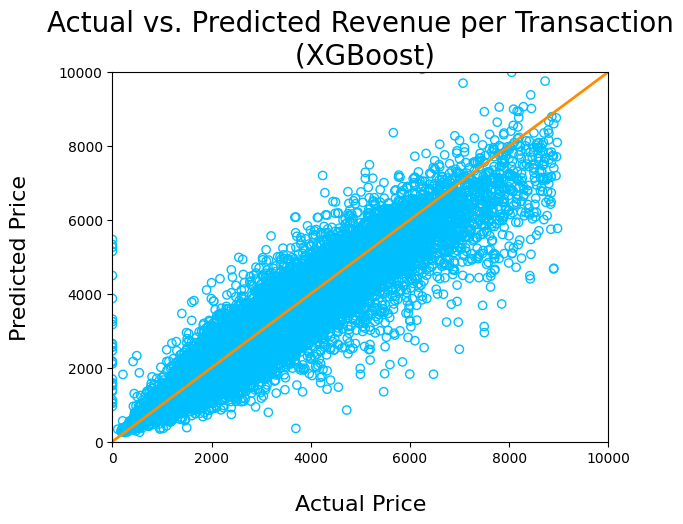

In [28]:
# Plot Actual vs. Predicted Revenue per Transaction
actual_price = np.expm1(y_test["subtotal_log"])
predicted_price = np.expm1(y_pred)

plt.figure()
plt.title("Actual vs. Predicted Revenue per Transaction\n (XGBoost)", fontsize=20)
plt.scatter(actual_price, predicted_price,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 10000], [0, 10000], "darkorange", lw=2)
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

#### b. Decision Tree Regressor

In [29]:
tuned_parameters_dt = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# GridSearch for Decision Tree
dtr_cv = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=tuned_parameters_dt,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearch on train set
dtr_cv.fit(X_train, y_train)

# Print best params and best R²
print(f"Best hyperparameters (Decision Tree): {dtr_cv.best_params_}\n")
print(f"Best R²: {dtr_cv.best_score_}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best hyperparameters (Decision Tree): {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}

Best R²: 0.7804148449504674


In [30]:
# Decision Tree Regressor with best hyperparameters
dtr_mod = DecisionTreeRegressor(
    random_state=42,
    max_depth=dtr_cv.best_params_["max_depth"],
    min_samples_split=dtr_cv.best_params_["min_samples_split"],
    min_samples_leaf=dtr_cv.best_params_["min_samples_leaf"]
)

# Fit the model
dtr_mod.fit(X_train, y_train)

# Predict on test set
y_pred_dtr = dtr_mod.predict(X_test)

# Print R² and RMSE
print(f"- {dtr_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred_dtr)}")
print(f"RMSE: {rmse_score(y_test, y_pred_dtr)}")

- DecisionTreeRegressor
R²: 0.7864838071742862
RMSE: 0.29215172928316685


In [31]:
# Save results
model_list.append(dtr_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred_dtr), 4))
rmse_list.append(round(rmse_score(y_test, y_pred_dtr), 4))

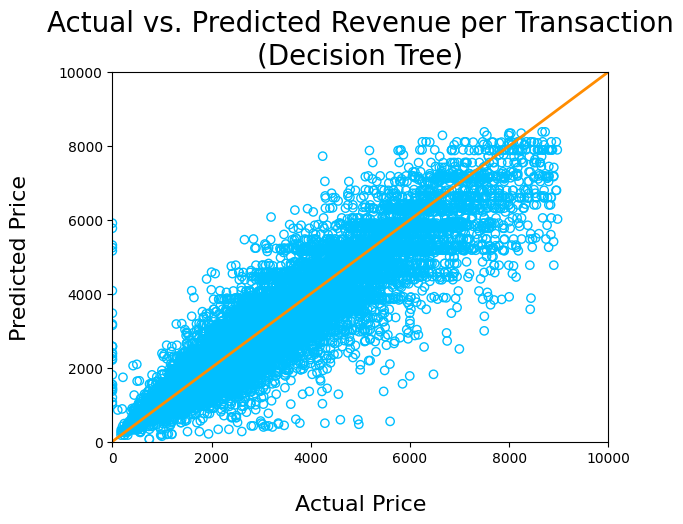

In [32]:
# Plot Actual vs. Predicted Revenue per Transaction
actual_price = np.expm1(y_test["subtotal_log"])
predicted_price = np.expm1(y_pred_dtr)

plt.figure()
plt.title("Actual vs. Predicted Revenue per Transaction\n(Decision Tree)", fontsize=20)
plt.scatter(actual_price, predicted_price,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 10000], [0, 10000], "darkorange", lw=2)
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

#### c. Huber Regression

In [33]:
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import GridSearchCV

# Define hyperparameters for HuberRegressor
tuned_parameters_huber = {
    "epsilon": [1.1, 1.35, 1.5],  # controls sensitivity to outliers
    "alpha": [0.0001, 0.001, 0.01]  # regularization term
}

# GridSearch for HuberRegressor
huber_cv = GridSearchCV(
    estimator=HuberRegressor(),
    param_grid=tuned_parameters_huber,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='r2'
)

# Fit GridSearch on train set
huber_cv.fit(X_train, y_train)

# Print best params and best R²
print(f"Best hyperparameters (Huber): {huber_cv.best_params_}\n")
print(f"Best R²: {huber_cv.best_score_}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best hyperparameters (Huber): {'alpha': 0.01, 'epsilon': 1.5}

Best R²: 0.7713111889019717


In [34]:
# Huber Regressor with best hyperparameters
huber_mod = HuberRegressor(
    epsilon=huber_cv.best_params_["epsilon"],
    alpha=huber_cv.best_params_["alpha"]
)

# Fit the model
huber_mod.fit(X_train, y_train)

# Predict on test set
y_pred_huber = huber_mod.predict(X_test)

# Print R² and RMSE
print(f"- {huber_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred_huber)}")
print(f"RMSE: {rmse_score(y_test, y_pred_huber)}")

- HuberRegressor
R²: 0.77389477523115
RMSE: 0.30064110001193683


In [35]:
# Save results
model_list.append(huber_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred_huber), 4))
rmse_list.append(round(rmse_score(y_test, y_pred_huber), 4))

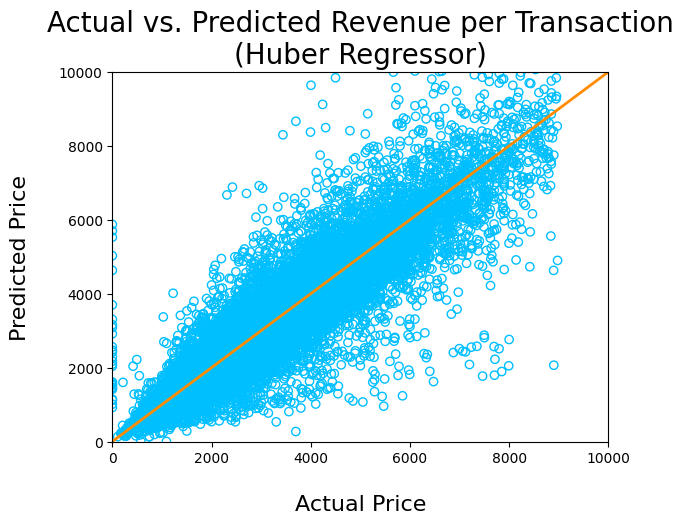

In [36]:
# Plot Actual vs. Predicted Revenue per Transaction
actual_price = np.expm1(y_test["subtotal_log"])
predicted_price = np.expm1(y_pred_huber)

plt.figure()
plt.title("Actual vs. Predicted Revenue per Transaction\n(Huber Regressor)", fontsize=20)
plt.scatter(actual_price, predicted_price,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 10000], [0, 10000], "darkorange", lw=2)
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

#### d. Random Forest Regressor

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters
param_dist_rf = {
    "n_estimators": [100, 200],
    "max_depth": [10, None],
    "max_features": ["sqrt"],
    "min_samples_split": [2, 5],
}

# RandomizedSearch
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=5,            # hanya 5 kombinasi acak
    cv=3,                # 3-fold cross-validation untuk hemat waktu
    n_jobs=-1,
    verbose=1,
    scoring="r2",
    random_state=42
)

# Fit RandomizedSearch
rf_random.fit(X_train, y_train)

# Print
print(f"Best hyperparameters (Random Forest): {rf_random.best_params_}\n")
print(f"Best R²: {rf_random.best_score_}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best hyperparameters (Random Forest): {'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': None}

Best R²: 0.7968114178483479


In [38]:
rf_mod = rf_random.best_estimator_

# Prediksi pada test set
y_pred_rf = rf_mod.predict(X_test)

# Evaluasi performa
print(f"- {rf_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred_rf)}")
print(f"RMSE: {rmse_score(y_test, y_pred_rf)}")

- RandomForestRegressor
R²: 0.8049895745834001
RMSE: 0.2792042132872842


In [39]:
model_list.append(rf_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred_rf), 4))
rmse_list.append(round(rmse_score(y_test, y_pred_rf), 4))

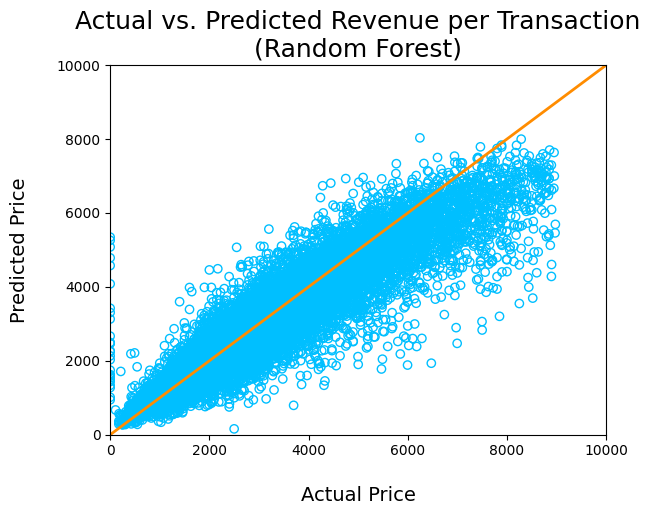

In [40]:
actual_price = np.expm1(y_test["subtotal_log"])
predicted_price = np.expm1(y_pred_rf)

plt.figure()
plt.title("Actual vs. Predicted Revenue per Transaction\n(Random Forest)", fontsize=18)
plt.scatter(actual_price, predicted_price,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 10000], [0, 10000], "darkorange", lw=2)
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.xlabel("\nActual Price", fontsize=14)
plt.ylabel("Predicted Price\n", fontsize=14)
plt.show()

#### e. LightGBM Regressor

In [41]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

# Define hyperparameters for LightGBM
tuned_parameters_lgb = {
    "num_leaves": [31, 50, 100],
    "max_depth": [-1, 10, 20],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 500]
}

# GridSearchCV
lgb_cv = GridSearchCV(
    estimator=LGBMRegressor(random_state=42),
    param_grid=tuned_parameters_lgb,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring="r2"
)

# Fit GridSearch
lgb_cv.fit(X_train, y_train)

# Print best params dan best R²
print(f"Best hyperparameters (LightGBM): {lgb_cv.best_params_}\n")
print(f"Best R²: {lgb_cv.best_score_}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1242
[LightGBM] [Info] Number of data points in the train set: 134328, number of used features: 40
[LightGBM] [Info] Start training from score 7.651698
Best hyperparameters (LightGBM): {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 31}

Best R²: 0.804546795117574


In [42]:
lgb_mod = LGBMRegressor(
    random_state=42,
    num_leaves=lgb_cv.best_params_["num_leaves"],
    max_depth=lgb_cv.best_params_["max_depth"],
    learning_rate=lgb_cv.best_params_["learning_rate"],
    n_estimators=lgb_cv.best_params_["n_estimators"]
)

# Fit model
lgb_mod.fit(X_train, y_train)

# Predict pada test set
y_pred_lgb = lgb_mod.predict(X_test)

# Print R² dan RMSE
print(f"- {lgb_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred_lgb)}")
print(f"RMSE: {rmse_score(y_test, y_pred_lgb)}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1242
[LightGBM] [Info] Number of data points in the train set: 134328, number of used features: 40
[LightGBM] [Info] Start training from score 7.651698
- LGBMRegressor
R²: 0.8111285107067103
RMSE: 0.2747743917765087


In [43]:
model_list.append(lgb_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred_lgb), 4))
rmse_list.append(round(rmse_score(y_test, y_pred_lgb), 4))

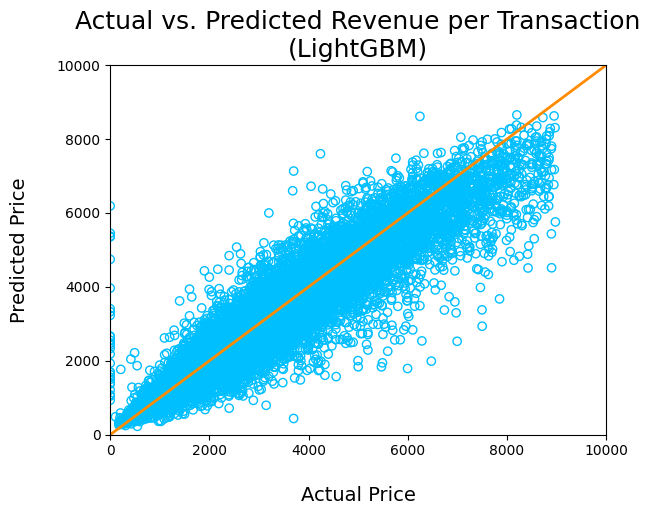

In [44]:
actual_price = np.expm1(y_test["subtotal_log"])
predicted_price = np.expm1(y_pred_lgb)

plt.figure()
plt.title("Actual vs. Predicted Revenue per Transaction\n(LightGBM)", fontsize=18)
plt.scatter(actual_price, predicted_price,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 10000], [0, 10000], "darkorange", lw=2)
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.xlabel("\nActual Price", fontsize=14)
plt.ylabel("Predicted Price\n", fontsize=14)
plt.show()

In [45]:
# Create a table with pd.DataFrame
model_results = pd.DataFrame(
    {
        "Model": model_list,
        "R²": r2_list,
        "RMSE": rmse_list
    }
)

model_results

,Model,R²,RMSE
0,XGBRegressor,0.8092,0.2762
1,DecisionTreeRegressor,0.7865,0.2922
2,HuberRegressor,0.7739,0.3006
3,RandomForestRegressor,0.8050,0.2792
4,LGBMRegressor,0.8111,0.2748
